In [1]:
# Planning Steps for this project:
# 1 import all necessary libraries and functions
# 2 read in data and explore
# 3 visualize data
# 4 feature eng: narrow down columns
# 5 feature eng: create new columns
# 6 set feature lists and prepare data for training
# 7 define pipeline with preprocessors and XGBRegressor model
# 8 fit the model and make predictions
# 9 make improvements and then use all training data
# 10 submit (woohoo)

In [2]:
# 1.1 import general libraries

In [3]:
import numpy as np
import pandas as pd
import sklearn as sk
import xgboost as xg
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# 1.2 import specific libraries

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# pipeline/preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

# xgboost
from xgboost import XGBRegressor

# feature engineering
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder

In [6]:
# 2.1 read in the data

In [7]:
# training data
train_df = pd.read_csv(r"C:\Users\miria\OneDrive\Documents\DS Learn\practice datasets\titanicsurvivaldata\titanic_train.csv")

# testing data
test_df = pd.read_csv(r"C:\Users\miria\OneDrive\Documents\DS Learn\practice datasets\titanicsurvivaldata\titanic_test.csv")

In [8]:
# 2.2 explore data

In [9]:
# display general info of train_df

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
# display the number of missing values for each columns

In [12]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
# 3.1 EDA visualization

C:\Users\miria\AppData\Local\Temp\ipykernel_29300\3664227044.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt1 = sns.countplot(x = 'Survived', data = train_df, palette = 'pastel')
C:\Users\miria\AppData\Local\Temp\ipykernel_29300\3664227044.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt1.set_xticklabels(labels = ['No', 'Yes'])


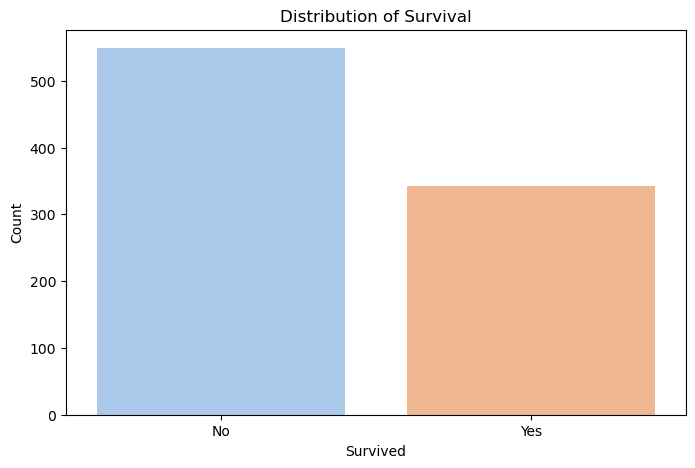

In [14]:
# plot the target variable
plt.figure(figsize = (8,5))
plt1 = sns.countplot(x = 'Survived', data = train_df, palette = 'pastel')
plt1.set(title = 'Distribution of Survival', xlabel = 'Survived', ylabel = 'Count')
plt1.set_xticklabels(labels = ['No', 'Yes'])
plt.show()

C:\Users\miria\AppData\Local\Temp\ipykernel_29300\3705366875.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt2.set_xticklabels(labels = ['No', 'Yes'])


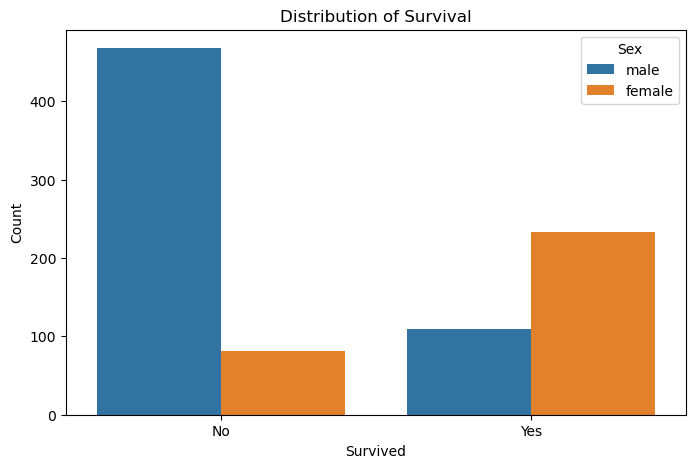

In [15]:
# same plot but putting the Sex variable in effect 
plt.figure(figsize = (8,5))
plt2 = sns.countplot(x = 'Survived', data = train_df, hue = 'Sex')
plt2.set(title = 'Distribution of Survival', xlabel = 'Survived', ylabel = 'Count')
plt2.set_xticklabels(labels = ['No', 'Yes'])
plt.show()

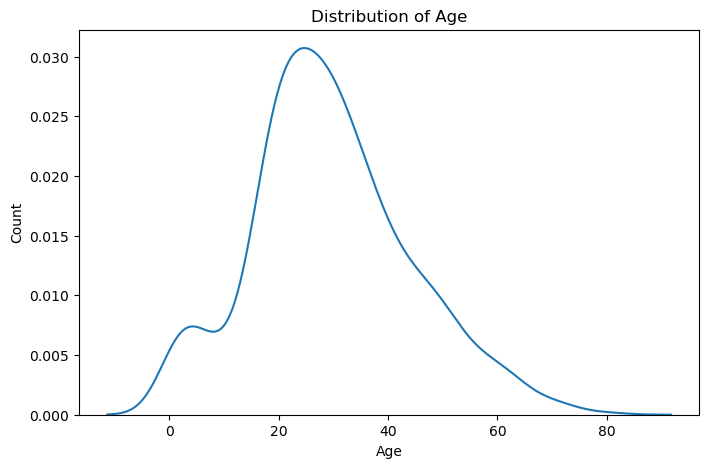

In [16]:
# plot distribution of Age 
plt.figure(figsize = (8,5))
plt2 = sns.kdeplot(x = 'Age', data = train_df)
plt2.set(title = 'Distribution of Age', xlabel = 'Age', ylabel = 'Count')
plt.show()

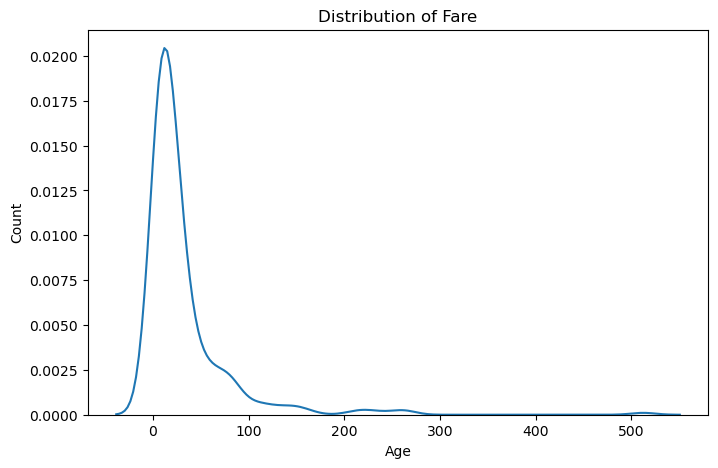

In [17]:
# plot distribution of Fare 
plt.figure(figsize = (8,5))
plt2 = sns.kdeplot(x = 'Fare', data = train_df)
plt2.set(title = 'Distribution of Fare', xlabel = 'Age', ylabel = 'Count')
plt.show()

In [18]:
# 3.2 handle NaN/missing values

In [19]:
# using interpolation to fill in missing values with estimated values
train_df.interpolate(method = 'linear', inplace = True)
test_df.interpolate(method = 'linear', inplace = True)

C:\Users\miria\AppData\Local\Temp\ipykernel_29300\1856818547.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_df.interpolate(method = 'linear', inplace = True)
C:\Users\miria\AppData\Local\Temp\ipykernel_29300\1856818547.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_df.interpolate(method = 'linear', inplace = True)


In [20]:
# 4.1 print list of mi_scores

In [21]:
X = train_df.copy()
y = X.pop("Survived")

# label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# ensure that all discrete features are of integer dtype
discrete_features = X.dtypes == int

mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns).sort_values(ascending = False)

# print out all values
pd.set_option('display.max_rows', 20)
mi_scores

Sex            0.160731
Fare           0.148973
Cabin          0.094581
Ticket         0.094353
Parch          0.054509
Pclass         0.026853
Embarked       0.018238
Name           0.016859
PassengerId    0.012490
Age            0.000000
SibSp          0.000000
Name: MI Scores, dtype: float64

In [22]:
# 4.2 cut down columns

# Removing embarked hurts score but removing cabin improvesit

In [23]:
# 5.1 create new simple features

In [24]:
# count for how many features qualify them to be a priority for survival (example: female)
def pitynumfunc(row):
    count = 0
    if row['Sex'] == 'female':
        count += 1
    if row['Age'] < 18:
        count += 1
    return count

train_df['pitynum'] = train_df.apply(pitynumfunc, axis = 1)
test_df['pitynum'] = test_df.apply(pitynumfunc, axis = 1)

In [25]:
# count for how big one's family is (including themselves)
train_df['familysize'] = train_df.SibSp + train_df.Parch + 1
test_df['familysize'] = test_df.SibSp + test_df.Parch + 1

In [26]:
# 6.1 determine numerical_columns and categorical_columns

In [27]:
numerical_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'pitynum', 'familysize']
categorical_columns = ['Sex', 'Ticket', 'Embarked']

# list of all features
features = numerical_columns + categorical_columns

In [28]:
# 6.2 set X and Y

In [29]:
X = train_df[features]
y = train_df['Survived']

In [30]:
# 6.3 train_test_split X and y

In [31]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [32]:
# 7.1 set preprocessor for numerical data

In [33]:
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', RobustScaler())
])

In [34]:
# 7.2 set preprocessor for categorical data

In [35]:
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', categories = 'auto', sparse_output = False))
])

In [36]:
# 7.3 combine preprocessors together into one

In [37]:
preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
])

In [38]:
# 7.4 use preprocessor on training data

In [39]:
encoder = preprocessor.fit(train_X)
train_X = encoder.transform(train_X)
val_X = encoder.transform(val_X)

In [40]:
# 8.1 set XGBRegressor model

In [41]:
t_model = XGBRegressor(n_estimators = 500,
                       learning_rate = 0.05,
                       random_state = 0,
                       early_stopping_rounds = 10,
                       enable_categorical = True
                      )

In [42]:
# 8.2 fit the model on data

In [43]:
t_model.fit(X = train_X,
            y = train_y,
            eval_set = [(val_X, val_y)])

[0]	validation_0-rmse:0.47171
[1]	validation_0-rmse:0.45973
[2]	validation_0-rmse:0.44882
[3]	validation_0-rmse:0.43862
[4]	validation_0-rmse:0.42935
[5]	validation_0-rmse:0.42079
[6]	validation_0-rmse:0.41307
[7]	validation_0-rmse:0.40589
[8]	validation_0-rmse:0.39945
[9]	validation_0-rmse:0.39375
[10]	validation_0-rmse:0.38821
[11]	validation_0-rmse:0.38313
[12]	validation_0-rmse:0.37881
[13]	validation_0-rmse:0.37504
[14]	validation_0-rmse:0.37132
[15]	validation_0-rmse:0.36811
[16]	validation_0-rmse:0.36528
[17]	validation_0-rmse:0.36277
[18]	validation_0-rmse:0.35956
[19]	validation_0-rmse:0.35724
[20]	validation_0-rmse:0.35484
[21]	validation_0-rmse:0.35291
[22]	validation_0-rmse:0.35107
[23]	validation_0-rmse:0.34945
[24]	validation_0-rmse:0.34788
[25]	validation_0-rmse:0.34627
[26]	validation_0-rmse:0.34528
[27]	validation_0-rmse:0.34410
[28]	validation_0-rmse:0.34232
[29]	validation_0-rmse:0.34175
[30]	validation_0-rmse:0.34129
[31]	validation_0-rmse:0.34000
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [44]:
# 8.3 make predictions using model and print mean absolute error

In [45]:
train_pred = t_model.predict(val_X)

# mae
initial_mae = mean_absolute_error(train_pred, val_y)
print(initial_mae)

0.2209043778612742


In [46]:
# 9.1 use preprocessor on all training data

In [47]:
all_encoder = preprocessor.fit(X)
X = all_encoder.transform(X)

In [48]:
# 9.2 fit model on all training data

In [49]:
t_model.fit(X = X,
            y = y,
            eval_set = [(X, y)])

[0]	validation_0-rmse:0.47252
[1]	validation_0-rmse:0.45974
[2]	validation_0-rmse:0.44769
[3]	validation_0-rmse:0.43646
[4]	validation_0-rmse:0.42601
[5]	validation_0-rmse:0.41616
[6]	validation_0-rmse:0.40695
[7]	validation_0-rmse:0.39818
[8]	validation_0-rmse:0.38993
[9]	validation_0-rmse:0.38219
[10]	validation_0-rmse:0.37487
[11]	validation_0-rmse:0.36794
[12]	validation_0-rmse:0.36157
[13]	validation_0-rmse:0.35585
[14]	validation_0-rmse:0.35057
[15]	validation_0-rmse:0.34545
[16]	validation_0-rmse:0.33997
[17]	validation_0-rmse:0.33538
[18]	validation_0-rmse:0.33056
[19]	validation_0-rmse:0.32607
[20]	validation_0-rmse:0.32197
[21]	validation_0-rmse:0.31816
[22]	validation_0-rmse:0.31432
[23]	validation_0-rmse:0.31032
[24]	validation_0-rmse:0.30659
[25]	validation_0-rmse:0.30324
[26]	validation_0-rmse:0.30015
[27]	validation_0-rmse:0.29734
[28]	validation_0-rmse:0.29424
[29]	validation_0-rmse:0.29188
[30]	validation_0-rmse:0.29009
[31]	validation_0-rmse:0.28849
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [50]:
# 9.3 make predictions on test data

In [51]:
test_X = test_df[features]

# use preprocessor on test data
test_X = encoder.transform(test_X)

# make predictions
test_preds = t_model.predict(test_X, validate_features = False)

# ensure predictions are output as 1s and 0s
test_preds = [round(value) for value in test_preds]

In [52]:
# 10 submit

In [53]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': test_preds})
output.to_csv(r"C:\Users\miria\OneDrive\Documents\DS Learn\output datasets\titanicsubmissions1.csv", index=False)

In [54]:
# 